# Generating Random Transitively Reduced Directed Acyclic Graphs (Generating Random Games Uniformly)
The very first step to getting "good" data for our agent to learn the game Upset-Downset needs to be getting a good sample of games to play. If we want our agent to learn Upset-Downset on games with **($\leq$ ?)** $n$ nodes, we want to make sure that every game on size $n$ has an equal likelihood of showing up during the training process. This boils down to generating transitively reduced directed acyclic graphs (DAGs) in a *unifrom* way. However, as we will see, this is far from straightforward.

Run the cell below to import the modules needed for this notebook.

In [1]:
%matplotlib inline
import randomDag as ugf
import randomUpDown as rud
import matplotlib.pyplot as plt
import digraph
import numpy as np
import copy
import upDown

### Transitive reduction
We start by recalling what transitive reduction means. **(should we talk about DAGs too since i left it out of the intro notebook? or do it to the intro notebook?)**

Consider the two DAGs $\,G=\{0:[1]\,, 1:[2]\,, 2:[]\, \}$ and $\,H=\{0:[1,2]\,, 1:[2]\,, 2:[]\, \}$. We use this notation to indicate adjacency relations and from that we infer further relations transitively. More precisely, this notation on $G$ tells us we have the relations $0>1$ and $1>2$ and $H$ has the relations  $0>1$, $0>2$ an $1>2$. But by transitivity, in $G$ we also have $0>2$, we just don't say that outloud. In Upset-Downset, both $G$ and $H$ give use the same game, so we only care about DAGs that have been reduced to their most transitive form. Run the next cell below to check that $G$ is the transitive reduction of $H.$

**(signs are in wrong direction :) Also what do you think of explaining with arrows? $0\rightarrow 1$ etc.)**

In [2]:
G = {0:[1],1:[2],2:[]}
H = {0:[1,2],1:[2],2:[]}
H = digraph.transitive_reduction(H)
G == H

True

We can even see they give us the same game by plotting them.
[We first turn them into UpDown objects from upDown]

**(can we use import * ?)**

In [3]:
G = {0:[1],1:[2],2:[]}
H = {0:[1,2],1:[2],2:[]}
G_game = upDown.UpDown(G)
H_game = upDown.UpDown(H)

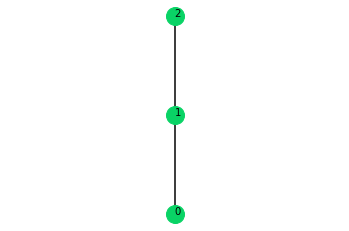

In [4]:
G_game.plot()

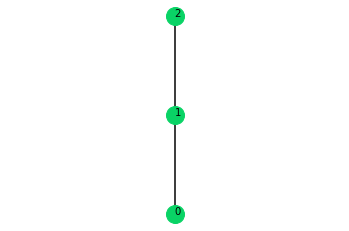

In [5]:
H_game.plot()

This is actually a bit silly because when we initialize an UpDown object, we convert its adjacency dictionary to its transitively reduced form.

### A naive approach

It is easy enough to naively generate a random DAG. Suppose we want a DAG on $n$ nodes. We could go through each tuple of unique nodes $(a,b), a\neq b$ (chosen in a uniformly random order, of course), flip a coin, and if the coin is heads, we try to add the edge. If adding the edge results in a cyclic graph, we don't add it. At the end, we take the transitive reduction of the graph. This seems simple enough. But, as we will see, it's naive of us to think it's going to give a uniform distibution. We implement this algorithm below.

Note: we use the functions is_acyclic and transitive_reduction from the digraph collection **(module?)**. The interested reader can look at the source code to see how those functions are implemented.

In [6]:
def naive_random_tr_dag(n):
    '''A naive generator for a random, transitively reduced, DAG on n nodes.'''
    DAG = {i:[] for i in range(n)}
    x = list(range(n))
    while x:
        i = np.random.choice(x)
        x.remove(i)
        y = list(range(n))
        y.remove(i)
        while y:
            j = np.random.choice(y)
            y.remove(j)
            flip = np.random.choice(['heads','tails'])
            if flip == 'heads':
                DAG_plus_e =  copy.deepcopy(DAG)
                DAG_plus_e[i].append(j)
                if digraph.is_acyclic(DAG_plus_e):
                    DAG = DAG_plus_e
    DAG = digraph.transitive_reduction(DAG)
    return DAG

Now let's test to see what the distribution of naive_random_tr_dag looks like if we use this algorithm to generate $10000$ random DAGs of size $3$. (Fact: there are $19$ possibilities. The proof of this is left to the reader =P.)

In [7]:
#    We collect the distribution in a dictionary keyed by strings
#of each DAGs dictionary representation. We sort the cover relations
#to make sure there is a one-to-one correspondence between these strings
#and the DAGs of order n.

naive_distibution = {}
#generate 10^k number of transitively reduced DAGs on n nodes
n = 3
k = 4
for i in range(10**k):
    l=[]
    X = naive_random_tr_dag(n)
    for j in range(n):
        X[j].sort()
    S = str(X)
    if S in naive_distibution:
        naive_distibution[S]+=1
    else:
        naive_distibution[S]=1
    
    #track the doneness
    if i % 10**(k-1) == 0:
        print(f'{i/10**(k-2)}% done')
print('all done')

0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
all done


Now let's plot the distribution to see how naive we were (run the code boxes below).

In [8]:
#A simple plotting function to plot the distribution of DAGs and tr DAGs.
#We use this throughout, so make sure to run this cell.
def plot_dist(labels, values, tr=False):
    fig, ax = plt.subplots()
    ax.bar(labels, values)
    if tr == True:
        plt.xlabel('Transitively Reduced DAGs')
    else:
        plt.xlabel('DAGs')
    plt.ylabel('Distribution')
    plt.show()

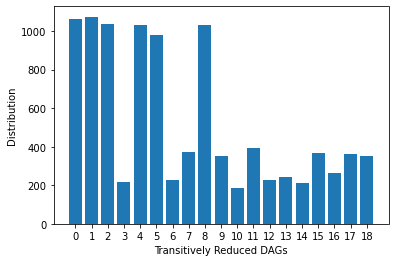

In [9]:
labels = [str(i) for i in range(len(naive_distibution))]
values = list(naive_distibution.values())
plot_dist(labels, values, tr=True)

You should see that $6$ of the DAGs are being favored. Let's look at one of them.

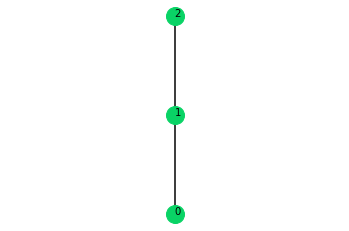

In [10]:
most_common_dag = max(naive_distibution, key=naive_distibution.get)
G_most = upDown.UpDown(eval(most_common_dag))
G_most.plot()

And also the DAG that shows up the least.

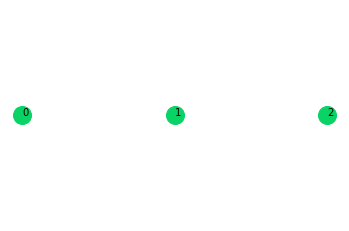

In [11]:
least_common_dag = min(naive_distibution, key=naive_distibution.get)
G_least = upDown.UpDown(eval(least_common_dag))
G_least.plot()

You can run this test again if you'd like, but you're likely to get similar results. In particular, a group of $6$ DAGs lead the pack and the empty DAG (one with no edges) tends to be the least likely DAG to show up. You are welcome to fiddle with the number of nodes too and see that this type of behavior only worsens. [Be warned, the number of DAGs grows pretty harshly with respect to the number of nodes, so the plot is likely to get pretty ugly for $n>4$.]

### Building intuition for a better generating function

Okay, so the naive approach doesn't work. But what's wrong with it? Well, there are two problems **(with)** our process. One of the problems is when we transitively reduce the DAG.

Why would transitive reduction throw off our distribution? One way to see this is to notice that the only DAG that transitively reduces to the empty DAG is the empty DAG. So, unless the DAG that's generated before we transitively reduce is the empty DAG, we won't end up with the empty DAG being generated. This shows us why we should expect that the empty DAG has a low probability of being generated with our naive approach.

Similarly, recall the two DAGs $\,G=\{0:[1]\,, 1:[2]\,, 2:[]\, \}$ and $\,H=\{0:[1,2]\,, 1:[2]\,, 2:[]\, \}$ from the beginning. Remember that $G$ is the transitive reduction of $H$? So if our process generates $G$ and $H$, we just end up with $G$. So again, it would not be surprising to see that $G$ has a higher distrubution in the end.

Let's see what happens to our distribution if we remove the transitive reduction step. We should expect that this increases the number of classes. We should see instead of $19$ we will get $25$.

In [12]:
def naive_random_dag(n):
    '''A naive generator for a random DAG on n nodes.'''
    DAG = {i:[] for i in range(n)}
    x = list(range(n))
    while x:
        i = np.random.choice(x)
        x.remove(i)
        y = list(range(n))
        y.remove(i)
        while y:
            j = np.random.choice(y)
            y.remove(j)
            flip = np.random.choice(['heads','tails'])
            if flip == 'heads':
                DAG_plus_e =  copy.deepcopy(DAG)
                DAG_plus_e[i].append(j)
                if digraph.is_acyclic(DAG_plus_e):
                    DAG = DAG_plus_e
    #DAG = digraph.transitive_reduction(DAG)
    return DAG

In [13]:
naive_distibution_dags = {}
n = 3
k = 4
for i in range(10**k):
    l=[]
    X = naive_random_dag(n)
    for j in range(n):
        X[j].sort()
    S = str(X)
    if S in naive_distibution_dags:
        naive_distibution_dags[S]+=1
    else:
        naive_distibution_dags[S]=1
    
    #track the doneness
    if i % 10**(k-1) == 0:
        print(f'{i/10**(k-2)}% done')
print('all done')

0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
all done


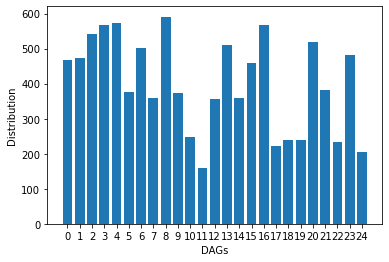

In [14]:
labels = [str(i) for i in range(len(naive_distibution_dags))]
values = list(naive_distibution_dags.values())
plot_dist(labels, values, tr=False)

The distribution is better, but still far from uniform. The problem that persists is a touch more nuanced then the problem of transitive reduction. Note that before we add an edge to our digraph, we check acyclicty. If we want to add the edge $e$, it is highly dependent on what the graph looks like before adding $e$. So instead of having this in our generation process, let's allow for any *digraph* to be created using our coin flips, and then only keep the the DAGs that are generated.

In [15]:
def random_digraph(n):
    '''A generator for a digraph on n nodes. Note many of these will have cycles.'''
    DAG = {i:[] for i in range(n)}
    x = list(range(n))
    while x:
        i = np.random.choice(x)
        x.remove(i)
        y = list(range(n))
        y.remove(i)
        while y:
            j = np.random.choice(y)
            y.remove(j)
            flip = np.random.choice(['heads','tails'])
            if flip == 'heads':
                DAG[i].append(j)
    return DAG

In [16]:
#    Here, we use random_digraph to uniformly generate digraphs, but we only keep the
#digraphs that are acyclic, the DAGs. One drawback is that we don't know how many objects we need to generate,
#so we use a while loop until we get 10000.

uniform_dag_distibution = {}

i = 0
n = 3
k = 4
while i < 10**k:
    l=[]
    X = random_digraph(n)
    if not digraph.is_acyclic(X):
        continue
    i += 1
    for j in range(n):
        X[j].sort()
    S = str(X)
    if S in uniform_dag_distibution:
        uniform_dag_distibution[S]+=1
    else:
        uniform_dag_distibution[S]=1
    if i % 10**(k-1) == 0:
        print(f'{i/10**(k-2)}% done')
print('all done')

10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
all done


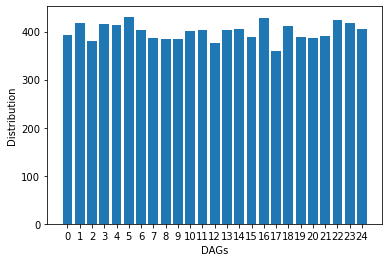

In [17]:
labels = [str(i) for i in range(len(uniform_dag_distibution))]
values = list(uniform_dag_distibution.values())
plot_dist(labels, values, tr=False)

Hooray! We finally did it, we got uniform distribution! We diagnosed the problems, but our picture is not perfect. We still don't even have a uniform generating function DAGs, since our function generates a digraph and then we check if it's acyclic. Of course we could incorporate that step into our function and have it keep generating digraphs until it comes across a DAG. But there's a better (faster) approach using Markov chains that we will investigate below. Not only that, we will see further that the Markov chain approach is also key in generating transitively reduced DAGs. Our ultimate goal!

### Generating uniform DAGs with a Markov chain

Our goal is to create a function that spits our transitively reduced DAGs in a uniform fashion. We will first resolve how to generate uniform DAGs.

The solution is simple and elegant and was first proposed by (Melanc¸on et al, 2000). The idea is to use a Markov chain. Start with any DAG (for example, the empty DAG with no edges). Label the nodes, $0,1,\dots,n-1$ and at each step in the chain, randomly draw two integers $(i,j)$, where $i,j<n$. If the edge is in the DAG, remove it, if it is not, add it as long as it does not create a cycle. This ensures that any change in the DAG from step $t$ to $t+1$ has equal likelihood of happening. Of course there is a chance the DAG does not change from step $t$ to step $t+1$ but allowing for enough steps in the chain, it's easy to see that every possible DAG with uniform distribution.

We can check this experimentally.

In [18]:
def dag_markov_step(X_t):
    '''An implementation of the Markov step described above.'''
    n = len(X_t)
    i = np.random.randint(n)
    j = np.random.randint(n)
    if i == j:
        X_t1 = X_t
    elif j in X_t[i]:
        X_t1 = X_t
        X_t1[i].remove(j)
    else:
        Y = copy.deepcopy(X_t)
        Y[i].append(j)
        if digraph.is_acyclic(Y):
            X_t1 = Y
        else:
            X_t1 = X_t
    return X_t1

In [19]:
def dag_markov_chain(DAG, steps):
    for i in range(steps):
        DAG = dag_markov_step(DAG)
    return DAG

We could turn dag_markov_chain into a DAG generating function by writing a function that initializes the empty DAG and runs the chain on a certain number of steps. This will work if we choose the number of steps to be large enough with respect to the number of nodes in the DAG (quadratic, cubic, etc.) But for our purposes, just to experimentall check the distribution, we will run the chain on $n$ steps where $n$ is the number of nodes and then start the next chain where the previous one left off (instead of always at the empty DAG).

In [20]:
uniform_dag_distibution_mc = {}

#choose the number of nodes n
n = 3
#initialize the empty DAG on n nodes
X = {i:[] for i in range(n)}
#generate a 10^k number of DAGs
k = 4
for i in range(10**k):
    X = dag_markov_chain(X, n)
    for j in range(n):
        X[j].sort()
    S = str(X)
    if S in uniform_dag_distibution_mc:
        uniform_dag_distibution_mc[S] += 1
    else:
        uniform_dag_distibution_mc[S] = 1
    if i % 10**(k-1) == 0:
        print(f'{i/10**(k-2)}% done')
print('all done')

0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
all done


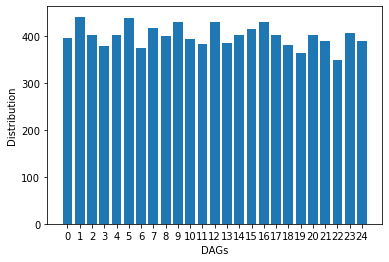

In [21]:
labels = [str(i) for i in range(len(uniform_dag_distibution_mc))]
values = list(uniform_dag_distibution_mc.values())
plot_dist(labels, values, tr=False)

Notice that generating these DAGs is much faster than before. In fact, you can increase the number DAGs generated (changing $k$) if you want to see an even more uniform distribution and it won't take much time for $k=5$.

### Generating transitively reduced DAGs (almost uniformly!)

We are nearly there! The last step is to incorporate a weighting trick introduced by (Patryk Kozieł and Małgorzata Sulkowska, 2018) into the Markov step. Recall that in the Markov step for generating a DAG, we allowed that any change had an equal likelihood of happening from steps $t$ to $t+1$. This is perfectly fine if we are not worried about DAGs that give us the same transitive reduction, but if we are (and we are), we want to make sure to boost the visibility of DAGs that won't show up as often after the transitive reduction. We do this by weighting the probabilites using the sizes of the *classes* each DAG shows up in. By classes, we simply mean that the DAGs $\,G$ and $H$ are in the same class if and only if the have the same transitive reduction. We will use the notation $|[G]|$ to represent the number
of DAGs (including $G$) that have the same transitive reduction as $G$. For example, if $G$ is the empty DAG, then $|[G]|=1$, since the the empty DAG is the only DAG whose transitive reduction is the empty DAG.

The curious reader is encouraged to read the paper by Kozieł and Sulkowska (https://arxiv.org/pdf/1810.05446.pdf). We won't go through every detail but we will present the algorithm, go through a small example, and show that we achieve (almost uniform) distribution of transitively reduced DAGs (finally). In particular, we won't cover how to calculate $|[G]|$ for a general DAG. This isn't hard, it's just a bit extra. (For an extra challenge, one can look at the source code for our implementation of it and try to figure out why it works =P)

### The final algorithm

The algorithm by Kozieł and Sulkowska is as follows:

Suppose we have a Markov chain of DAGs on $n$ nodes $X_0,X_1,\dots,X_t,X_{t+1},\dots, X_s$ where $X_0$ is any DAG (for example the empty DAG) and the nodes are labeled $0,1,\dots,n-1$. To get from step $t$ to step $t+1$, draw random integers $i,j<n$.
1. If $(i,j)$ is an edge of $X_t$, let $Z$ be the DAG with $(i,j)$ removed. Let $p = \frac{|[X_t]|}{|[Z]|}$.
    Set $X_{t+1}=Z$ with probability $p$ and $X_{t+1}=X_t$ with probability $p-1$. 
2. If $(i,j)$ is not an edge of $X_t$, let $Y$ be the digraph with $(i,j)$ added. If $Y$ is acyclic, then 
   let $p = \frac{|[X_t]|}{|[Y]|}$. Set $X_{t+1}=Y$ with probability $p$ and $X_{t+1}=X_t$ with probability $p-1$.
   If $Y$ contains a cycle, set $X_{t+1}=X_t$.
   
Repeat this process and take the transitive reduction of $X_s$.

### An explicit example
**(You can skip this boring calculation if you just want to get to the uniform distribution)**

Let's look at a concrete example of how this affects the Markov step. Consider the DAG on $3$ nodes $X_t=\{0:[1],1:[],2:[]\}$. (Run the cell below to plot it.)

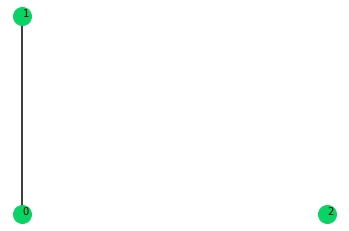

In [22]:
X_t = upDown.UpDown({0:[1],1:[],2:[]})
X_t.plot()

Let's compute the probability distribution for the step $t$ to $t+1$.

If we drew the pairs $(0,0), (1,1), (2,2),$ and $(1,0)$ we would get a cycle if we added that edge, so there would be no change from $X_t$ to $X_{t+1}$. Now what about the other five options: $(0,1), (0,2), (1,2), (2,0), (2,1)$?

Let's list the possibilities for $X_{t+1}$.

$X_{t+1} = X_t$ (no change)

$X_{t+1} = G_0 = \{0:[],1:[],2:[]\}$ (remove $(0,1)$)

$X_{t+1} = G_1 = \{0:[1,2],1:[],2:[]\}$ (add $(0,2)$)

$X_{t+1} = G_2 = \{0:[1],1:[2],2:[]\}$ (add $(1,2)$)

$X_{t+1} = G_3 = \{0:[1],1:[],2:[0]\}$ (add $(2,0)$)

$X_{t+1} = G_4 = \{0:[1],1:[],2:[1]\}$ (add $(2,1)$)

G_0:


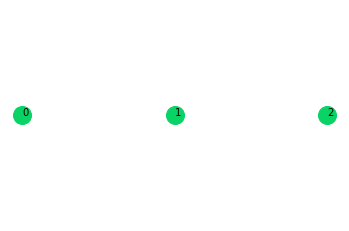

G_1:


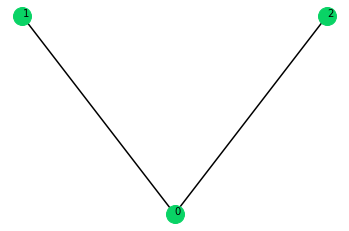

G_2:


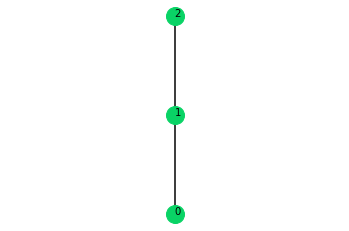

G_3:


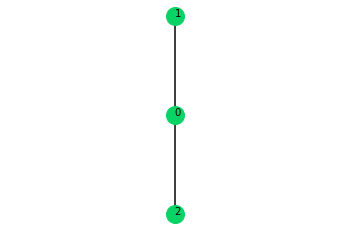

G_4:


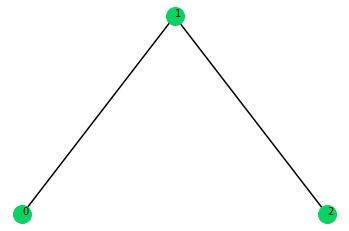

In [23]:
#You can look at them (if you really want to.)

G_0 = upDown.UpDown({0:[],1:[],2:[]})
G_1 = upDown.UpDown({0:[1,2],1:[],2:[]})
G_2 = upDown.UpDown({0:[1],1:[2],2:[]})
G_3 = upDown.UpDown({0:[1],1:[],2:[0]})
G_4 = upDown.UpDown({0:[1],1:[],2:[1]})
print('G_0:')
G_0.plot()
print('G_1:')
G_1.plot()
print('G_2:')
G_2.plot()
print('G_3:')
G_3.plot()
print('G_4:')
G_4.plot()

After calculating the class sizes, we get $|[X_t]|=1$, $|[G_0]|=1$, $|[G_1]|=1$, $|[G_2]|=2$, $|[G_3]|=2$, and $|[G_4]|=1$ (the reader can verify this). This means that if $(0,1)$, $(0,2)$, or $(2,1)$ are drawn the algorithm will tell us to change to that since $p=1$. If $(1,2)$ or $(2,0)$ are drawn, we will have $p=\frac{1}{2}$. The event of drawing a pair of nonnegative integers $(i,j)$ where $i,j<3$ is independent from the event of adding or removing that edge. Thus we have,

$\mathbb{P}(X_{t+1} = G_0) = \frac{1}{9}*1=\frac{1}{9}$

$\mathbb{P}(X_{t+1} = G_1) = \frac{1}{9}*1=\frac{1}{9}$

$\mathbb{P}(X_{t+1} = G_2) = \frac{1}{9}*\frac{1}{2}=\frac{1}{18}$

$\mathbb{P}(X_{t+1} = G_3) = \frac{1}{9}*\frac{1}{2}=\frac{1}{18}$

$\mathbb{P}(X_{t+1} = G_4) = \frac{1}{9}*1=\frac{1}{9}$

and

$\mathbb{P}(X_{t+1} = X_t) = 1 - \sum \mathbb{P}(X_{t+1} = G_i) = \frac{5}{9}$

### Using the algorithm

We have already implemented the algorithm into a function in the module uniform_generating_function but here we will only use the markov_chain function from that module. One thing to notice when we use this markov_chain function is that it accepts the class size (class *cardinality*) of the starting DAG. We do this because computing the class size is one of the more complicated steps in the algorithm and since a markov chain is iterative, we can use the information from previous steps rather than recalculating it each time.

In the paper by Kozieł and Sulkowska, they conjecture that the process should give uniformity after $n^2$ steps where
$n$ is the number of nodes. In our experiement below, we only use $n$ steps, but as we did above, each time we use the Markov chain, we start with the DAG from the end of the previous chain.

In [24]:
'''The transitive reduction markov chain function'''
tr_dag_markov_chain = ugf.markov_chain

In [25]:
'''Here, we run the transitive reduction DAG markov chain process 10**k times with n steps in each chain.
    Each time, we start with the DAG from the end of the previous chain. This ensures that after
    n iterations, we will be a quadratic number of steps away. As long as we run the process enough times,
    we will get a uniform distribution as conjectured.'''

uniform_tr_dag_distibution_mc = {}
#choose the number of nodes n
n = 3
#initialize the empty DAG on n nodes. cc (class cardinality) will always be 1.
X = {i:[] for i in range(n)}
cc = 1 #don't change
#generate a 10^k number of DAGs
k = 4
for i in range(10**k):
    X, cc = tr_dag_markov_chain(X, n, cc=cc)
    
    #We only store the transitive reduction of the output of the markov chain.
    Y = digraph.transitive_reduction(X)
    for j in range(n):
        Y[j].sort()
    S = str(Y)
    if S in uniform_tr_dag_distibution_mc:
        uniform_tr_dag_distibution_mc[S] += 1
    else:
        uniform_tr_dag_distibution_mc[S] = 1
    if i % 10**(k-1) == 0:
        print(f'{i/10**(k-2)}% done')
print('all done')

0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
all done


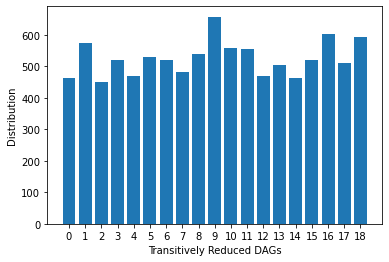

In [26]:
labels = [str(i) for i in range(len(uniform_tr_dag_distibution_mc))]
values = list(uniform_tr_dag_distibution_mc.values())
plot_dist(labels, values, tr=True)

Awesome!

## Citations

@article{kozieł2018uniform,
      title={Uniform random posets}, 
      author={Patryk Kozieł and Małgorzata Sulkowska},
      year={2018},
      eprint={1810.05446},
      archivePrefix={arXiv},
      primaryClass={math.CO}
}

@article{melanccon2001random,
  title={Random generation of directed acyclic graphs},
  author={Melan{\c{c}}on, Guy and Dutour, Isabelle and Bousquet-M{\'e}lou, Mireille},
  journal={Electronic Notes in Discrete Mathematics},
  volume={10},
  pages={202--207},
  year={2001},
  publisher={Elsevier}
}